# Investigate Betting Strategies Based On Simple Rules For Estimating Fighter's Prob of Winning 


In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.max_columns', 500)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy.random
import statsmodels.nonparametric
import scipy.stats

In [71]:
bets = pd.read_csv('../../../data/datasets_for_analysis/final_datasets/odds_w_outcomes.csv')
bets['Card_Date'] = pd.to_datetime(bets['Card_Date'] )
bets['year'] = bets['Card_Date'].dt.year

In [72]:
print(str(bets.shape[0]/2)+ " "+
      'fights in the dataset from '+str(bets.year.min())+' to '+
     str(bets.year.max()))

print(bets.Outcome.value_counts())
bets = bets[bets.Outcome == 'def']

print(str(bets.shape[0]/2)+ " "+
      'fights in the dataset that did not result in a NC or draw from '+str(bets.year.min())+' to '+
     str(bets.year.max()))
display(bets.head())

4702.0 fights in the dataset from 2008 to 2020
def    9240
vs      164
Name: Outcome, dtype: int64
4620.0 fights in the dataset that did not result in a NC or draw from 2008 to 2020


,fighter1,fighter2,fight_odds_url,Bet,5Dimes,Bet365,BetDSI,BetOnline,BookMaker,Bovada,Intertops,Pinnacle,SportBet,SportsInt,Sportsbook,William_H,meanodds,5Dimes_vig,BetDSI_vig,BookMaker_vig,SportBet_vig,Bet365_vig,Bovada_vig,Sportsbook_vig,William_H_vig,Pinnacle_vig,SportsInt_vig,BetOnline_vig,Intertops_vig,Winner_Cleaned,Loser_Cleaned,wiki_url,bestfightodds_winner,bestfightodds_loser,WeightClass,Winner,Outcome,Loser,Method,Round,Time,Notes,Card,Winner_url,Loser_url,event_order,Method_Cleaned,Card_Cleaned,Champion,Interim_Champion,Card_Date,#,Event,bet_won,year
0,Aalon Cruz,Spike Carlyle,https://www.bestfightodds.com/events/ufc-on-es...,Aalon Cruz,1.540541,1.571429,1.510204,1.540541,1.50000,1.500000,1.526316,1.515464,1.537634,1.555556,1.540541,1.5,1.528185,0.019493,0.042390,0.054264,0.022097,0.036364,0.051282,0.049123,0.051282,0.037222,0.051020,0.033738,0.055172,Spike Carlyle,Aalon Cruz,https://en.wikipedia.org/wiki/UFC_Fight_Night:...,Spike Carlyle,Aalon Cruz,Featherweight,Spike Carlyle,def,Aalon Cruz,TKO (punches),1.0,1:25,NaN,Preliminary card (ESPN+),NaN,NaN,11,KO,Prelim,NaN,NaN,2020-02-29,511,UFC Fight Night: Benavidez vs. Figueiredo,0,2020
1,Aalon Cruz,Spike Carlyle,https://www.bestfightodds.com/events/ufc-on-es...,Spike Carlyle,2.700000,2.500000,2.630000,2.600000,2.58000,2.600000,2.500000,2.650000,2.690000,2.450000,2.500000,2.6,2.583333,0.019493,0.042390,0.054264,0.022097,0.036364,0.051282,0.049123,0.051282,0.037222,0.051020,0.033738,0.055172,Spike Carlyle,Aalon Cruz,https://en.wikipedia.org/wiki/UFC_Fight_Night:...,Spike Carlyle,Aalon Cruz,Featherweight,Spike Carlyle,def,Aalon Cruz,TKO (punches),1.0,1:25,NaN,Preliminary card (ESPN+),NaN,NaN,11,KO,Prelim,NaN,NaN,2020-02-29,511,UFC Fight Night: Benavidez vs. Figueiredo,1,2020
2,Aaron Phillips,Matt Hobar,https://www.bestfightodds.com/events/ufc-fight...,Aaron Phillips,2.880000,NaN,2.800000,2.800000,2.80000,2.750000,NaN,2.840000,2.830000,2.700000,2.800000,NaN,2.800000,0.019353,0.034562,0.034562,0.030776,NaN,0.055944,0.049451,NaN,0.024244,0.059811,0.034562,NaN,Matt Hobar,Aaron Phillips,https://en.wikipedia.org/wiki/UFC_Fight_Night:...,Matt Hobar,Aaron Phillips,Bantamweight,Matt Hobar,def,Aaron Phillips,"Decision (unanimous) (29–28, 29–28, 29–28)",3.0,5:00,NaN,Preliminary card (Fox Sports 2),https://en.wikipedia.org/wiki/Matt_Hobar,NaN,9,Unanimous Decision,Prelim,NaN,NaN,2014-08-23,287,UFC Fight Night: Henderson vs. dos Anjos,0,2014
3,Aaron Phillips,Matt Hobar,https://www.bestfightodds.com/events/ufc-fight...,Matt Hobar,1.487805,NaN,1.476190,1.476190,1.47619,1.444444,NaN,1.487805,1.476190,1.450450,1.444444,NaN,1.468857,0.019353,0.034562,0.034562,0.030776,NaN,0.055944,0.049451,NaN,0.024244,0.059811,0.034562,NaN,Matt Hobar,Aaron Phillips,https://en.wikipedia.org/wiki/UFC_Fight_Night:...,Matt Hobar,Aaron Phillips,Bantamweight,Matt Hobar,def,Aaron Phillips,"Decision (unanimous) (29–28, 29–28, 29–28)",3.0,5:00,NaN,Preliminary card (Fox Sports 2),https://en.wikipedia.org/wiki/Matt_Hobar,NaN,9,Unanimous Decision,Prelim,NaN,NaN,2014-08-23,287,UFC Fight Night: Henderson vs. dos Anjos,1,2014
4,Aaron Phillips,Sam Sicilia,https://www.bestfightodds.com/events/ufc-173-b...,Aaron Phillips,2.300000,NaN,2.250000,2.300000,2.25000,2.250000,NaN,2.320000,2.280000,2.300000,2.300000,NaN,2.283333,0.018116,0.036281,0.036281,0.025373,NaN,0.052288,0.050167,NaN,0.024530,0.055995,0.034783,NaN,Sam Sicilia,Aaron Phillips,https://en.wikipedia.org/wiki/UFC_173,Sam Sicilia,Aaron Phillips,Featherweight,Sam Sicilia,def,Aaron Phillips,"Decision (unanimous) (29–28, 29–28, 30–27)",3.0,5:00,NaN,Preliminary card (UFC Fight Pass),https://en.wikipedia.org/wiki/Sam_Sicilia,NaN,11,Unanimous Decision,Prelim,NaN,NaN,2014-05-24,273,UFC 173: Barão vs. Dillashaw,0,2014


In [73]:
# convert decimal odds to probabilities using the balanced book method
betting_sites= ['5Dimes','BetDSI','BookMaker','SportBet','Bet365','Bovada', 
                'Sportsbook','William_H','Pinnacle','SportsInt','BetOnline','Intertops']

for col in betting_sites:
    bets[col+"_prob"] =  ((bets[col]**-1) - bets[col+"_vig"])/(1-bets[col+"_vig"]) 

bets["avg_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("mean", axis = 1)

,avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.082853,0.047619,-0.035234,42
"(0.1, 0.15000000000000002]",0.130845,0.107143,-0.023703,140
"(0.15000000000000002, 0.2]",0.177782,0.166667,-0.011115,336
"(0.2, 0.25]",0.226675,0.213018,-0.013657,507
"(0.25, 0.30000000000000004]",0.276361,0.261654,-0.014707,665
"(0.30000000000000004, 0.35000000000000003]",0.326098,0.332882,0.006784,739
"(0.35000000000000003, 0.4]",0.376106,0.419608,0.043502,765
"(0.4, 0.45]",0.422837,0.457560,0.034722,754
"(0.45, 0.5]",0.475653,0.463596,-0.012057,673


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     949.3
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.13e-15
Time:                        14:20:28   Log-Likelihood:                 38.261
No. Observations:                  18   AIC:                            -72.52
Df Residuals:                      16   BIC:                            -70.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.017     -0.052      0.9

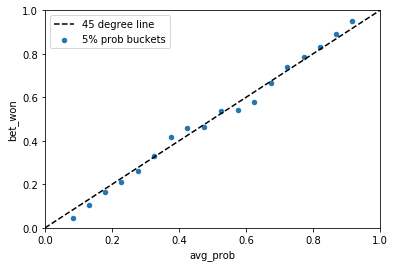

In [74]:
# how well does the average probability track actual outcomes

bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets.avg_prob, divided)
grouped = bets.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
display(grouped[['avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_prob', y = 'bet_won', ax = ax, label = '5% prob buckets')
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())



It looks like the average probability has closely predicted the true probability with possibly a little opportunity in the 35 - 45 % probability range where underdogs seem to be winning ~4% more often than the average probabilities suggest. This seems worth investigating further. What may be happening here is a lot of money is flowing to one side of what should be a close matchup, thereby making one side a better bet

,avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.082984,0.050000,-0.032984,40
"(0.1, 0.15000000000000002]",0.130285,0.115044,-0.015241,113
"(0.15000000000000002, 0.2]",0.176919,0.157025,-0.019894,242
"(0.2, 0.25]",0.227397,0.211940,-0.015457,335
"(0.25, 0.30000000000000004]",0.276686,0.247748,-0.028938,444
"(0.30000000000000004, 0.35000000000000003]",0.325810,0.331301,0.005490,492
"(0.35000000000000003, 0.4]",0.376810,0.436945,0.060135,563
"(0.4, 0.45]",0.423088,0.463497,0.040409,589
"(0.45, 0.5]",0.475704,0.465887,-0.009817,513


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.971
Model:                            WLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     536.7
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           9.81e-14
Time:                        14:20:29   Log-Likelihood:                 33.482
No. Observations:                  18   AIC:                            -62.96
Df Residuals:                      16   BIC:                            -61.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0028      0.023     -0.119      0.9

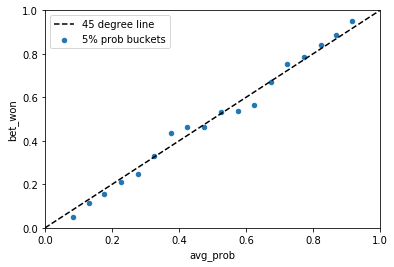

In [75]:
# repeat analysis but look at more recent years and older years separately
# recent years 2013 - 2020
bets_recent = bets[bets.year >= 2013]
bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
display(grouped[['avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_prob', y = 'bet_won', ax = ax, label = '5% prob buckets')
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

,avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.080233,0.000000,-0.080233,2
"(0.1, 0.15000000000000002]",0.133191,0.074074,-0.059116,27
"(0.15000000000000002, 0.2]",0.180005,0.191489,0.011485,94
"(0.2, 0.25]",0.225269,0.215116,-0.010153,172
"(0.25, 0.30000000000000004]",0.275707,0.289593,0.013885,221
"(0.30000000000000004, 0.35000000000000003]",0.326672,0.336032,0.009360,247
"(0.35000000000000003, 0.4]",0.374143,0.371287,-0.002856,202
"(0.4, 0.45]",0.421941,0.436364,0.014422,165
"(0.45, 0.5]",0.475490,0.456250,-0.019240,160


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.994
Model:                            WLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2649.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           3.32e-19
Time:                        14:20:30   Log-Likelihood:                 45.314
No. Observations:                  18   AIC:                            -86.63
Df Residuals:                      16   BIC:                            -84.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0034      0.010      0.331      0.7

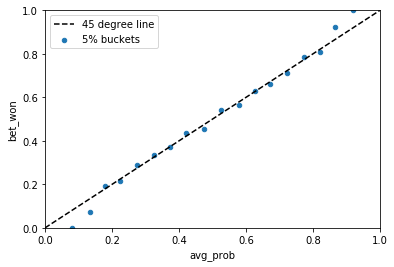

In [76]:
# repeat analysis but look at older years separately (2008 - 2012)

bets_recent = bets[bets.year < 2013]
bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
display(grouped[['avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_prob', y = 'bet_won', ax = ax, label = "5% buckets")
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

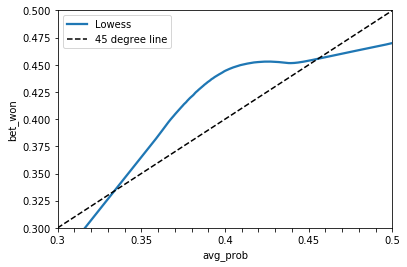

In [77]:
# It looks like the overperformance of fighters in the 35% - 45% range
# is a phenomena that's only occured since 2013
# let's investigate this further

bets_recent = bets[(bets.year >= 2013)& (bets.avg_prob >= .3) & (bets.avg_prob <= .5)].copy()
fig, ax = plt.subplots()
sns.regplot('avg_prob', 'bet_won', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess')
x = np.linspace(.3, .5, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_xticks(np.arange(.3,.51,.01))
ax.set_ylim(.3,.5)
ax.set_xlim(.3,.5)
ax.set_xticklabels([round(x,2) if i%5 == 0 else '' for i, x in enumerate(np.arange(.3,.51,.01))])
ax.legend(loc='best')

In [78]:
# do some statistical tests to see if this overperformance is statistically significant
bins = np.arange(.3, .5, .025)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                   num_bet_won =  ('bet_won', 'sum'),      
                                                                      n = ('bet_won', 'size')
                                                                         )
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_prob']
grouped['p_val'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won, x.n, x.avg_prob), axis = 1)
del grouped['num_bet_won']
display(grouped[['avg_prob', 'bet_won', 'diff', 'n', 'p_val']])

,avg_prob,bet_won,diff,n,p_val
avg_prob,,,,,
"(0.3, 0.325]",0.312333,0.330396,0.018063,227,0.566951
"(0.325, 0.35000000000000003]",0.337355,0.332075,-0.005279,265,0.896702
"(0.35000000000000003, 0.37500000000000006]",0.362830,0.427984,0.065154,243,0.038473
"(0.37500000000000006, 0.4000000000000001]",0.387426,0.443750,0.056324,320,0.044442
"(0.4000000000000001, 0.4250000000000001]",0.411668,0.464968,0.053300,314,0.058428
"(0.4250000000000001, 0.4500000000000001]",0.436128,0.461818,0.025690,275,0.395206
"(0.4500000000000001, 0.47500000000000014]",0.463080,0.457831,-0.005249,249,0.898943


It looks like fighters in the 35% - 42.5% range did very well from 2013 - 2020

## Investigate if Using Information About Sites' Vigs Gives Better/Different Information

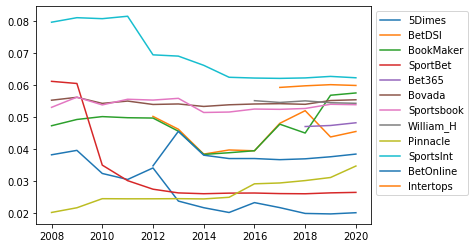

In [79]:
## how have vigs changed over time

fig1, ax1 = plt.subplots()
yeargroup = bets.groupby('year')
for col in betting_sites:
     s = yeargroup.agg(avg_vig= (col+'_vig', 'mean')).reset_index()
     ax1.plot(s.year,s.avg_vig, label = col)
ax1.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Looks like Vigs have gone down accross most betting sites over time, but there are still a decent amount of high vig sites

In [80]:
# how do results change if I use probability from betting site with lowest vig for each fight
# rather than the average probability?

bets["lowest_vig"] = bets[[col+"_vig" for col in betting_sites]].apply(pd.Series.idxmin, axis = 1)
print(bets["lowest_vig"].value_counts())
bets["lowest_vig_prob"] = bets.lookup(bets.index, bets["lowest_vig"].apply(lambda x: x[0:-3]+"prob"))

5Dimes_vig        6400
Pinnacle_vig      2044
SportBet_vig       708
BookMaker_vig       64
Sportsbook_vig      16
Bovada_vig           6
BetDSI_vig           2
Name: lowest_vig, dtype: int64


,avg_lowest_vig_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.086626,0.047619,-0.039007,42
"(0.1, 0.15000000000000002]",0.133531,0.107143,-0.026388,140
"(0.15000000000000002, 0.2]",0.182196,0.166667,-0.015530,336
"(0.2, 0.25]",0.231919,0.213018,-0.018901,507
"(0.25, 0.30000000000000004]",0.280772,0.261654,-0.019118,665
"(0.30000000000000004, 0.35000000000000003]",0.329894,0.332882,0.002989,739
"(0.35000000000000003, 0.4]",0.378453,0.419608,0.041155,765
"(0.4, 0.45]",0.423617,0.457560,0.033943,754
"(0.45, 0.5]",0.474713,0.463596,-0.011117,673


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     961.2
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.02e-15
Time:                        14:20:33   Log-Likelihood:                 38.370
No. Observations:                  18   AIC:                            -72.74
Df Residuals:                      16   BIC:                            -70.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0093    

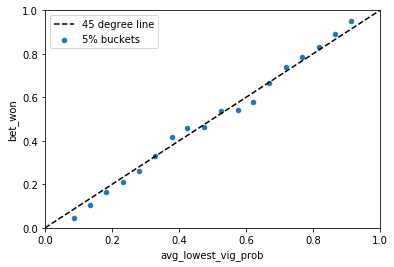

In [81]:
# how well does the lowest vig probability track actual outcomes

bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets.avg_prob, divided)
grouped = bets.groupby(consensus_group)['bet_won', "lowest_vig_prob"].agg(avg_lowest_vig_prob = ('lowest_vig_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['avg_lowest_vig_prob']
display(grouped[['avg_lowest_vig_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='avg_lowest_vig_prob', y = 'bet_won', ax = ax, label = "5% buckets")
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--', label = '45 degree line')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ avg_lowest_vig_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

In [82]:
# compare log loss of simple average versus lowest vig probability

print('avg_prob:',np.mean(-np.log(bets[bets.bet_won == 1]['avg_prob'])))
print('lowest_vig_prob:',np.mean(-np.log(bets[bets.bet_won == 1]["lowest_vig_prob"])))

# on average assigning a 54% win chance to the winning side
print('avg_prob:',np.exp(-np.mean(-np.log(bets[bets.bet_won == 1]['avg_prob']))))
print('lowest_vig_prob:',np.exp(-np.mean(-np.log(bets[bets.bet_won == 1]['lowest_vig_prob']))))


# compare brier score of simple average versus lowest vig probability

print('avg_prob:',np.mean((1 - bets[bets.bet_won == 1]['avg_prob'])**2))
print('lowest_vig_prob:',np.mean((1 - bets[bets.bet_won == 1]['lowest_vig_prob'])**2))

avg_prob: 0.6129427637823484
lowest_vig_prob: 0.613142360910794
avg_prob: 0.5417542661806614
lowest_vig_prob: 0.5416461443755684
avg_prob: 0.21264426496661923
lowest_vig_prob: 0.21270026772241665


It looks like the average probability is a slightly better predictor than the lowest vig probability, but the difference is extremely minor/may not be statistically significant

,vig_wtd_avg_prob,bet_won,diff,n
avg_prob,,,,
"(0.05, 0.1]",0.083388,0.047619,-0.035769,42
"(0.1, 0.15000000000000002]",0.131498,0.107143,-0.024355,140
"(0.15000000000000002, 0.2]",0.179196,0.166667,-0.012529,336
"(0.2, 0.25]",0.228365,0.213018,-0.015347,507
"(0.25, 0.30000000000000004]",0.277594,0.261654,-0.015940,665
"(0.30000000000000004, 0.35000000000000003]",0.327237,0.332882,0.005645,739
"(0.35000000000000003, 0.4]",0.376855,0.419608,0.042753,765
"(0.4, 0.45]",0.422945,0.457560,0.034615,754
"(0.45, 0.5]",0.475312,0.463596,-0.011716,673


                            WLS Regression Results                            
Dep. Variable:                bet_won   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     953.0
Date:                Fri, 24 Apr 2020   Prob (F-statistic):           1.09e-15
Time:                        14:20:38   Log-Likelihood:                 38.295
No. Observations:                  18   AIC:                            -72.59
Df Residuals:                      16   BIC:                            -70.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0034      0.017  

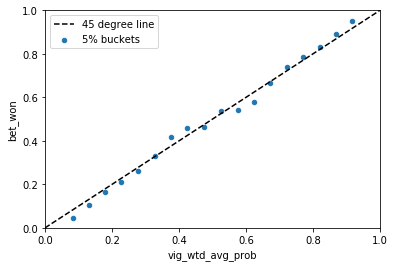

In [83]:
# Instead of using lowest vig probability try a weighted average using the inverse of the
# vig as weights (lower vig sites get more weight)

wtd_avg = pd.Series(0, bets.index)
for col in betting_sites:
    wtd_avg += np.where(bets[col+"_prob"].isna(),0,bets[col+"_prob"]*(1/bets[col+"_vig"]))
wtd_avg = wtd_avg/(bets[[col+"_vig" for col in betting_sites]].apply(lambda x: np.sum(x**-1), axis = 1))
bets["vig_wtd_avg_prob"] = wtd_avg 


bins = np.arange(0,1, .05)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets.avg_prob, divided)
grouped = bets.groupby(consensus_group)['bet_won', "vig_wtd_avg_prob"].agg(vig_wtd_avg_prob = ('vig_wtd_avg_prob', 'mean'),
                                                                   bet_won=('bet_won', 'mean'),
                                                                      n = ('bet_won', 'size'))
grouped = grouped[grouped.bet_won.notna()]
grouped['diff'] = grouped['bet_won'] - grouped['vig_wtd_avg_prob']
display(grouped[['vig_wtd_avg_prob','bet_won','diff', 'n']])

fig, ax = plt.subplots()
grouped.plot.scatter(x='vig_wtd_avg_prob', y = 'bet_won', ax = ax, label = "5% buckets")
x = np.linspace(0, 1, 100)
ax.plot(x, x, 'k--', label = '45 degree line')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.legend(loc='best')
model = smf.wls(formula='bet_won ~ vig_wtd_avg_prob', data=grouped, weights = grouped.n).fit()
print(model.summary())

In [84]:
# compare log loss of simple average versus inverse vig weighted avg probability

print('avg_prob:', np.mean(-np.log(bets[bets.bet_won == 1]['avg_prob'])))
print('vig_wtd_avg_prob:', np.mean(-np.log(bets[bets.bet_won == 1]['vig_wtd_avg_prob'])))

# on average assigning a 54% win chance to the winning side
print('avg_prob:',np.exp(-np.mean(-np.log(bets[bets.bet_won == 1]['avg_prob']))))
print('vig_wtd_avg_prob:', np.exp(-np.mean(-np.log(bets[bets.bet_won == 1]['vig_wtd_avg_prob']))))


# compare brier score of simple average versus inverse vig weighted avg probability

print('avg_prob:',np.mean((1 - bets[bets.bet_won == 1]['avg_prob'])**2))
print('vig_wtd_avg_prob:', np.mean((1 - bets[bets.bet_won == 1]['vig_wtd_avg_prob'])**2))

avg_prob: 0.6129427637823484
vig_wtd_avg_prob: 0.6128690445432554
avg_prob: 0.5417542661806614
vig_wtd_avg_prob: 0.5417942053650646
avg_prob: 0.21264426496661923
vig_wtd_avg_prob: 0.21260554820381236


Looks like the an inverse vig weighted average performs slightly better than a simple average, although again the difference may not be statistically signifcant

# Investigate Betting Strategy Based on Mispricing Opportunities

count    9240.000000
mean        0.053968
std         0.043402
min         0.000000
25%         0.027570
50%         0.042309
75%         0.066171
max         0.648740
Name: biggest_pct_diff, dtype: float64

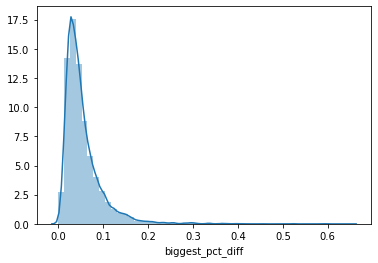

In [85]:
# how much variation is there in vig adjusted probabilities accross the betting sites

bets["max_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("max", axis = 1)
bets["min_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("min", axis = 1)
bets["max_pct_diff"] = np.abs(bets["max_prob"]/bets["avg_prob"] - 1)
bets["min_pct_diff"] = np.abs(bets["min_prob"]/bets["avg_prob"] - 1)
bets["biggest_pct_diff"] = bets[["min_pct_diff", "max_pct_diff"]].apply("max", axis = 1)
sns.distplot(bets["biggest_pct_diff"])
bets["biggest_pct_diff"].describe()

It looks like the probabilities accross sites track eachother closely/tend to be very close to the average probability (~5 percent (percent, not percentage points) above or below the average probability). After accounting for the vig, it doesn't look like there will be enough price outliers to make a consistent profit based on odds mispricing.

In [86]:
# bet only if pd -1 >= r to earn expected value of at least r dollars
# first try using the average probability accross sites
# assuming I always bet at best odds avaiable

bets['best_odds'] = bets[betting_sites].apply("max", axis = 1)
bets['return'] = np.where(bets['bet_won'] == 1, bets['best_odds'] -1, -1)
bets["best_odds_site"] = bets[[col for col in betting_sites]].apply(pd.Series.idxmax, axis = 1)
bets['breakeven_prob'] = 1/bets['best_odds']
bets["best_odds_vig"] = bets['breakeven_prob'] - bets.lookup(bets.index, bets["best_odds_site"].apply(lambda x: x+"_prob"))
print(bets["best_odds_vig"].describe())

count    9240.000000
mean        0.015995
std         0.010313
min         0.001127
25%         0.009130
50%         0.013032
75%         0.019579
max         0.073556
Name: best_odds_vig, dtype: float64


In [87]:
def get_return(df, r, prob_col):
    df['pd_minus1'] = df['best_odds']*df[prob_col] - 1
    num_fights = df.groupby('year').agg(total_fights = ('pd_minus1', lambda x: x.size/2)).reset_index()
    df = df[df['pd_minus1'] >= r].copy()

    out = df.groupby('year').agg(num_bets = ('pd_minus1', "size"),
                           avg_odds = ('best_odds', "mean"),
                           avg_breakeven_prob = ('breakeven_prob', "mean"),
                           pct_won = ('bet_won', "mean"),
                           avg_estimated_vig = ('best_odds_vig', "mean"),
                           avg_return = ('return', "mean"),
                           std_return = ('return', 'std')
                          ).reset_index()
    out = pd.merge(num_fights, out, on = 'year')
    out['% fights bet'] = out['num_bets']/out['total_fights']
    return out[['year', 'total_fights', 'num_bets', '% fights bet', 'avg_odds', 
                'avg_breakeven_prob', 'pct_won','avg_estimated_vig', 'avg_return', 'std_return']]

In [88]:
## try betting based on mispricing using the average probability

for r in [.01, .02, .03, .04, .05, .06]:
    print("r = "+str(r))
    display(get_return(bets, r, 'avg_prob'))

r = 0.01


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,87,0.435000,1.635352,0.657247,0.701149,0.011223,0.068936,0.769768
1,2009,212.0,77,0.363208,1.712354,0.627750,0.584416,0.014863,-0.043379,0.899509
2,2010,250.0,70,0.280000,1.495015,0.692628,0.671429,0.009634,-0.043781,0.706843
3,2011,295.0,68,0.230508,1.419033,0.716269,0.720588,0.008807,-0.001285,0.642068
4,2012,333.0,89,0.267267,1.605958,0.657023,0.584270,0.015340,-0.128948,0.773305
5,2013,376.0,78,0.207447,1.559864,0.669332,0.653846,0.012380,-0.047933,0.728700
6,2014,493.0,95,0.192698,1.591439,0.660167,0.673684,0.012568,0.015685,0.774763
7,2015,464.0,97,0.209052,1.735301,0.643213,0.680412,0.015671,0.068270,0.841330
8,2016,482.0,94,0.195021,1.597412,0.659823,0.648936,0.016338,-0.005255,0.810454
9,2017,445.0,119,0.267416,1.681360,0.635438,0.647059,0.014975,0.009243,0.810019


r = 0.02


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,32,0.160000,1.851907,0.604131,0.593750,0.012661,-0.040443,0.885886
1,2009,212.0,27,0.127358,1.752342,0.617958,0.592593,0.013155,-0.048928,0.861321
2,2010,250.0,24,0.096000,1.471409,0.696700,0.625000,0.007813,-0.121193,0.711300
3,2011,295.0,23,0.077966,1.431476,0.709056,0.782609,0.010053,0.089735,0.600215
4,2012,333.0,24,0.072072,1.879726,0.570563,0.458333,0.020319,-0.187532,0.952790
5,2013,376.0,22,0.058511,1.654798,0.630099,0.727273,0.016665,0.131442,0.753604
6,2014,493.0,17,0.034483,1.888927,0.558928,0.529412,0.022396,0.066534,1.113031
7,2015,464.0,36,0.077586,2.024119,0.557345,0.722222,0.022844,0.307411,0.977193
8,2016,482.0,32,0.066390,1.734434,0.620551,0.593750,0.021381,0.013473,0.968179
9,2017,445.0,44,0.098876,1.814827,0.602824,0.613636,0.019698,0.022976,0.906077


r = 0.03


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,12,0.060000,2.184554,0.536206,0.416667,0.014712,-0.240569,0.988461
1,2009,212.0,6,0.028302,2.019200,0.503968,0.500000,0.018171,-0.016197,1.106482
2,2010,250.0,9,0.036000,1.534659,0.677052,0.555556,0.007926,-0.246229,0.719080
3,2012,333.0,11,0.033033,2.201166,0.487616,0.545455,0.024815,0.098576,1.110178
4,2013,376.0,6,0.015957,1.883333,0.555301,0.833333,0.022344,0.450000,0.766201
5,2014,493.0,7,0.014199,2.134742,0.496506,0.714286,0.031389,0.553375,1.194658
6,2015,464.0,20,0.043103,2.083710,0.523592,0.800000,0.023897,0.606210,1.023978
7,2016,482.0,15,0.031120,1.968296,0.538225,0.666667,0.027772,0.308301,1.080924
8,2017,445.0,14,0.031461,2.081449,0.522374,0.500000,0.024999,-0.095503,1.008098
9,2018,471.0,39,0.082803,2.112522,0.533882,0.692308,0.023596,0.304954,1.054944


r = 0.04


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,5,0.025000,2.030267,0.525315,0.400000,0.017051,-0.145072,1.206479
1,2009,212.0,3,0.014151,1.967607,0.524187,1.000000,0.020702,0.967607,0.396419
2,2012,333.0,6,0.018018,2.557527,0.411863,0.333333,0.028829,-0.158333,1.304767
3,2013,376.0,2,0.005319,2.085714,0.510490,0.500000,0.025105,-0.214286,1.111168
4,2014,493.0,3,0.006085,2.255278,0.474998,0.666667,0.027476,0.632090,1.578101
5,2015,464.0,9,0.019397,2.451376,0.435472,0.666667,0.032157,0.645820,1.389833
6,2016,482.0,7,0.014523,1.931950,0.549236,0.571429,0.030296,0.069312,1.101262
7,2017,445.0,8,0.017978,2.104625,0.523276,0.375000,0.024363,-0.320040,1.024295
8,2018,471.0,28,0.059448,2.317827,0.486450,0.607143,0.025497,0.258476,1.196027
9,2019,507.0,4,0.007890,2.850000,0.371352,0.500000,0.024349,0.662500,2.034443


r = 0.05


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,2,0.010000,2.665000,0.375935,0.500000,0.024930,0.275000,1.803122
1,2009,212.0,1,0.004717,2.150000,0.465116,1.000000,0.032303,1.150000,NaN
2,2012,333.0,3,0.009009,2.615054,0.423412,0.000000,0.031105,-1.000000,0.000000
3,2013,376.0,1,0.002660,1.571429,0.636364,1.000000,0.016946,0.571429,NaN
4,2014,493.0,1,0.002028,1.746269,0.572650,1.000000,0.011020,0.746269,NaN
5,2015,464.0,5,0.010776,2.542476,0.414209,0.600000,0.032559,0.612476,1.622397
6,2016,482.0,5,0.010373,2.095328,0.499366,0.600000,0.033554,0.241481,1.218767
7,2017,445.0,6,0.013483,2.201608,0.502622,0.333333,0.025300,-0.322947,1.130974
8,2018,471.0,20,0.042463,2.599925,0.423161,0.500000,0.027415,0.199092,1.363206
9,2019,507.0,3,0.005917,2.966667,0.361803,0.666667,0.024918,1.216667,2.089458


r = 0.06


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,2,0.010000,2.665000,0.375935,0.500000,0.024930,0.275000,1.803122
1,2012,333.0,2,0.006006,2.122581,0.496229,0.000000,0.027450,-1.000000,0.000000
2,2014,493.0,1,0.002028,1.746269,0.572650,1.000000,0.011020,0.746269,NaN
3,2015,464.0,4,0.008621,2.690000,0.389713,0.500000,0.031836,0.527500,1.860491
4,2016,482.0,2,0.004149,2.284615,0.461180,0.500000,0.036788,0.400000,1.979899
5,2017,445.0,5,0.011236,2.369465,0.456338,0.200000,0.028098,-0.460000,1.207477
6,2018,471.0,14,0.029724,2.614179,0.434648,0.500000,0.027437,0.152274,1.367871
7,2019,507.0,3,0.005917,2.966667,0.361803,0.666667,0.024918,1.216667,2.089458
8,2020,92.0,1,0.010870,1.571429,0.636364,1.000000,0.027853,0.571429,NaN


In [89]:
## try betting based on mispricing using the inverse vig weighted average probability

for r in [.01, .02, .03, .04, .05, .06]:
    print("r = "+str(r))
    display(get_return(bets, r, 'vig_wtd_avg_prob'))

r = 0.01


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,57,0.285000,1.608639,0.652682,0.684211,0.014995,0.039283,0.765179
1,2009,212.0,57,0.268868,1.677809,0.632854,0.649123,0.017367,0.071122,0.892720
2,2010,250.0,44,0.176000,1.537753,0.680390,0.636364,0.011648,-0.107392,0.700718
3,2011,295.0,37,0.125424,1.666302,0.659809,0.675676,0.014192,-0.038405,0.690541
4,2012,333.0,70,0.210210,1.755951,0.619852,0.528571,0.019535,-0.186725,0.811693
5,2013,376.0,53,0.140957,1.581203,0.667986,0.603774,0.016140,-0.110527,0.770094
6,2014,493.0,64,0.129817,1.659428,0.647798,0.640625,0.017295,0.010675,0.849886
7,2015,464.0,83,0.178879,1.733785,0.638421,0.698795,0.018618,0.117370,0.854637
8,2016,482.0,88,0.182573,1.738353,0.625654,0.625000,0.020375,-0.008481,0.850225
9,2017,445.0,96,0.215730,1.747328,0.624187,0.656250,0.019540,0.063567,0.866168


r = 0.02


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,18,0.090000,1.632477,0.644675,0.611111,0.017534,-0.063498,0.829204
1,2009,212.0,13,0.061321,1.759656,0.592365,0.846154,0.020151,0.447165,0.726554
2,2010,250.0,11,0.044000,1.471057,0.697936,0.545455,0.007971,-0.241619,0.736556
3,2011,295.0,6,0.020339,1.504221,0.672237,0.833333,0.017262,0.281999,0.645910
4,2012,333.0,23,0.069069,1.973647,0.548561,0.434783,0.024042,-0.213225,0.965426
5,2013,376.0,19,0.050532,1.693278,0.627531,0.736842,0.020253,0.177497,0.813256
6,2014,493.0,15,0.030426,2.028201,0.539246,0.533333,0.029198,0.062657,1.107435
7,2015,464.0,32,0.068966,2.078891,0.549308,0.656250,0.025087,0.186993,1.029281
8,2016,482.0,37,0.076763,1.921009,0.582276,0.594595,0.024681,0.041555,0.977720
9,2017,445.0,41,0.092135,1.852360,0.594862,0.609756,0.022421,0.018043,0.913348


r = 0.03


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,8,0.040000,1.869079,0.563274,0.375000,0.019819,-0.274881,1.041985
1,2009,212.0,4,0.018868,1.903800,0.534582,0.750000,0.027581,0.415705,0.982215
2,2012,333.0,8,0.024024,2.345841,0.455783,0.375000,0.028097,-0.170221,1.181810
3,2013,376.0,6,0.015957,1.819511,0.576773,0.666667,0.019857,0.145437,0.922714
4,2014,493.0,8,0.016227,2.085313,0.496306,0.625000,0.033571,0.347450,1.201819
5,2015,464.0,18,0.038793,2.354545,0.490394,0.666667,0.029223,0.360101,1.162211
6,2016,482.0,19,0.039419,1.957495,0.546411,0.578947,0.028749,0.146782,1.115929
7,2017,445.0,21,0.047191,2.023825,0.530047,0.571429,0.024994,0.074208,1.023161
8,2018,471.0,45,0.095541,2.215037,0.509629,0.577778,0.026120,0.100779,1.091508
9,2019,507.0,16,0.031558,1.984988,0.566938,0.500000,0.021497,-0.078079,1.185177


r = 0.04


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,3,0.015000,2.318333,0.455751,0.333333,0.023391,-0.150000,1.472243
1,2009,212.0,1,0.004717,2.150000,0.465116,1.000000,0.032303,1.150000,NaN
2,2012,333.0,6,0.018018,2.311122,0.471656,0.333333,0.029731,-0.301961,1.127736
3,2013,376.0,2,0.005319,2.085714,0.510490,0.500000,0.025105,-0.214286,1.111168
4,2014,493.0,5,0.010142,2.243167,0.464797,0.600000,0.035922,0.429254,1.398269
5,2015,464.0,11,0.023707,2.292010,0.473320,0.727273,0.029255,0.632919,1.246117
6,2016,482.0,12,0.024896,2.116664,0.507083,0.666667,0.032513,0.413458,1.182003
7,2017,445.0,11,0.024719,2.197000,0.494942,0.454545,0.025603,-0.110029,1.087336
8,2018,471.0,30,0.063694,2.313187,0.493059,0.566667,0.025864,0.139578,1.170863
9,2019,507.0,7,0.013807,2.419926,0.445695,0.428571,0.024366,0.194898,1.654127


r = 0.05


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,1,0.005000,2.550000,0.392157,1.000000,0.041762,1.550000,NaN
1,2009,212.0,1,0.004717,2.150000,0.465116,1.000000,0.032303,1.150000,NaN
2,2012,333.0,4,0.012012,2.611290,0.413713,0.250000,0.031645,-0.350000,1.300000
3,2013,376.0,1,0.002660,1.571429,0.636364,1.000000,0.016946,0.571429,NaN
4,2014,493.0,3,0.006085,2.255278,0.474998,0.666667,0.027476,0.632090,1.578101
5,2015,464.0,7,0.015086,2.416054,0.448925,0.714286,0.032279,0.751769,1.405242
6,2016,482.0,7,0.014523,2.213696,0.481391,0.571429,0.035039,0.351058,1.380395
7,2017,445.0,7,0.015730,2.208521,0.494311,0.285714,0.026065,-0.419669,1.063675
8,2018,471.0,22,0.046709,2.608265,0.424669,0.500000,0.029347,0.152962,1.310911
9,2019,507.0,4,0.007890,2.668798,0.412182,0.500000,0.021883,0.662500,2.034443


r = 0.06


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,1,0.005000,2.550000,0.392157,1.000000,0.041762,1.550000,NaN
1,2012,333.0,2,0.006006,2.122581,0.496229,0.000000,0.027450,-1.000000,0.000000
2,2014,493.0,1,0.002028,1.746269,0.572650,1.000000,0.011020,0.746269,NaN
3,2015,464.0,5,0.010776,2.542476,0.414209,0.600000,0.032559,0.612476,1.622397
4,2016,482.0,4,0.008299,2.579808,0.407513,0.500000,0.040901,0.512500,1.756120
5,2017,445.0,5,0.011236,2.369465,0.456338,0.200000,0.028098,-0.460000,1.207477
6,2018,471.0,19,0.040340,2.702553,0.412889,0.421053,0.028874,0.017465,1.363874
7,2019,507.0,4,0.007890,2.668798,0.412182,0.500000,0.021883,0.662500,2.034443
8,2020,92.0,1,0.010870,1.571429,0.636364,1.000000,0.027853,0.571429,NaN


# Investigate Betting Strategy Based On Betting On Fighters with Avg Probability of Winning = 35% - 42.5% 

In [91]:
def get_return_based_on_prob_range(df, prob_col, prob_min, prob_max):
    num_fights = df.groupby('year').agg(total_fights = ('pd_minus1', lambda x: x.size/2)).reset_index()
    df = df[(df[prob_col] >= prob_min) & (df[prob_col] <= prob_max)].copy()
    df['breakeven_prob'] = 1/df['best_odds']
    out = df.groupby('year').agg(num_bets = ('pd_minus1', "size"),
                           avg_odds = ('best_odds', "mean"),
                           avg_breakeven_prob = ('breakeven_prob', "mean"),
                           pct_won = ('bet_won', "mean"),
                           avg_estimated_vig = ('best_odds_vig', "mean"),
                           avg_return = ('return', "mean"),
                           std_return = ('return', 'std')
                          ).reset_index()
    out = pd.merge(num_fights, out, on = 'year')
    out['% fights bet'] = out['num_bets']/out['total_fights']
    return out[['year', 'total_fights', 'num_bets', '% fights bet', 'avg_odds', 
                'avg_breakeven_prob', 'pct_won', 'avg_estimated_vig', 'avg_return', 'std_return']]
print('bets with avg vig adjusted probability in the .35 to .425 range')
display(get_return_based_on_prob_range(bets, 'avg_prob', .35, .425))

bets with avg vig adjusted probability in the .35 to .425 range


,year,total_fights,num_bets,% fights bet,avg_odds,avg_breakeven_prob,pct_won,avg_estimated_vig,avg_return,std_return
0,2008,200.0,46,0.230000,2.519348,0.398165,0.391304,0.019464,-0.015217,1.244356
1,2009,212.0,47,0.221698,2.542553,0.394605,0.404255,0.018934,0.026170,1.263056
2,2010,250.0,71,0.284000,2.548310,0.393734,0.366197,0.019191,-0.068028,1.237816
3,2011,295.0,60,0.203390,2.504667,0.400230,0.366667,0.016412,-0.083167,1.218036
4,2012,333.0,77,0.231231,2.549221,0.393364,0.350649,0.023610,-0.103766,1.230626
5,2013,376.0,85,0.226064,2.539412,0.394782,0.411765,0.019718,0.034824,1.247290
6,2014,493.0,120,0.243408,2.521167,0.397743,0.408333,0.016452,0.029500,1.247008
7,2015,464.0,115,0.247845,2.541217,0.394488,0.504348,0.016722,0.284087,1.281674
8,2016,482.0,137,0.284232,2.511168,0.399351,0.496350,0.016703,0.245401,1.262597
9,2017,445.0,114,0.256180,2.519474,0.398050,0.421053,0.019804,0.066754,1.259438


# Use Simulation to Determine How Accurate Avg_Prob is as Predictor of True Probability

In [318]:
def log_loss(p, y):
    return -np.mean(y*np.log(p)+(1-y)*np.log(1 - p))

def brier(p, y):
    return np.mean(y*(1 - p)**2 + (1-y)*(p**2))

winning_probs = bets.loc[bets['bet_won'] == 1, "avg_prob"]
print(len(winning_probs))
sim = 1000
df = pd.DataFrame()
df['brier'] = np.repeat(np.nan, sim)
df['log_loss'] = np.nan
numpy.random.seed(22)
for k in range(sim):
    y = np.random.binomial(1, winning_probs)
    df['brier'].iloc[k] = brier(winning_probs, y)
    df['log_loss'].iloc[k] =log_loss(winning_probs, y)
print(df.describe())   

print(-np.mean(np.log(bets[bets.bet_won == 1]['avg_prob'])))
print(np.mean((1 - bets[bets.bet_won == 1]['avg_prob'])**2))


4620
             brier     log_loss
count  1000.000000  1000.000000
mean      0.212728     0.613977
std       0.002419     0.005405
min       0.206530     0.599728
25%       0.211010     0.610183
50%       0.212639     0.613797
75%       0.214322     0.617538
max       0.220540     0.630765
0.6129427637823484
0.21264426496661923
